# ZRE Projekt - 2023
#### Honza Černocký a Honza Pavlus, FIT VUT Brno, 2023
#### ` Celkem bodů 29`
---

Principem projektu oprava signálů narušených klipováním pomocí lineární predikce nebo jiných technik. Nachystali jsme 100 signálů z TIMITu tak, že máte k disposici originál i klipovanou verzi. Klipovaná verze simuluje ztrátu nejvyššího bitu. Signály a seznam viz https://www.fit.vutbr.cz/study/courses/ZRE/public/2022-23/. 

Projekt doporučujeme řešit v Pythonu v Google Colab, ale je možné použít i jiný jazyk / prostředí, v tomto případě prosím zašlete protokol a zdrojáky emailem.  

---



In [1]:
# nacteni signalu a listu, at to nemusite hledat
import os

if not os.path.exists('proj_zre_2023.tgz'):
    !wget https://www.fit.vutbr.cz/study/courses/ZRE/public/2022-23/proj_zre_2023.tgz
    !tar xfz proj_zre_2023.tgz
!ls

# make graphs interactive
!pip install mpld3
%matplotlib inline
import scipy
#import mpld3
#mpld3.enable_notebook()

clipped_signals        list_students.txt  proj_zre_2023.tgz    venv
kitic13declipping.pdf  orig_signals	  RBAR_icassp2015.pdf  zreprojekt.ipynb

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Úloha 1 - Detektor klipovaných signálů - `2 body `

Navrhněte a naprogramujte detektor klipovaných částí signálu. Pozor, klipované mohou být jak kladné, tak záporné vzorky. Zobrazte několik příkladů těchto klipovaných částí v časové a ve frekvenční oblasti (spektrogram). 

---

Kipované části detekuji pomocí hledání vzorků, které mají absolutní hodnotu >= maximu amplitudy signálu. Výsledkem je pole indexů klipovaných vzorků z funkce `detect_clipped`.

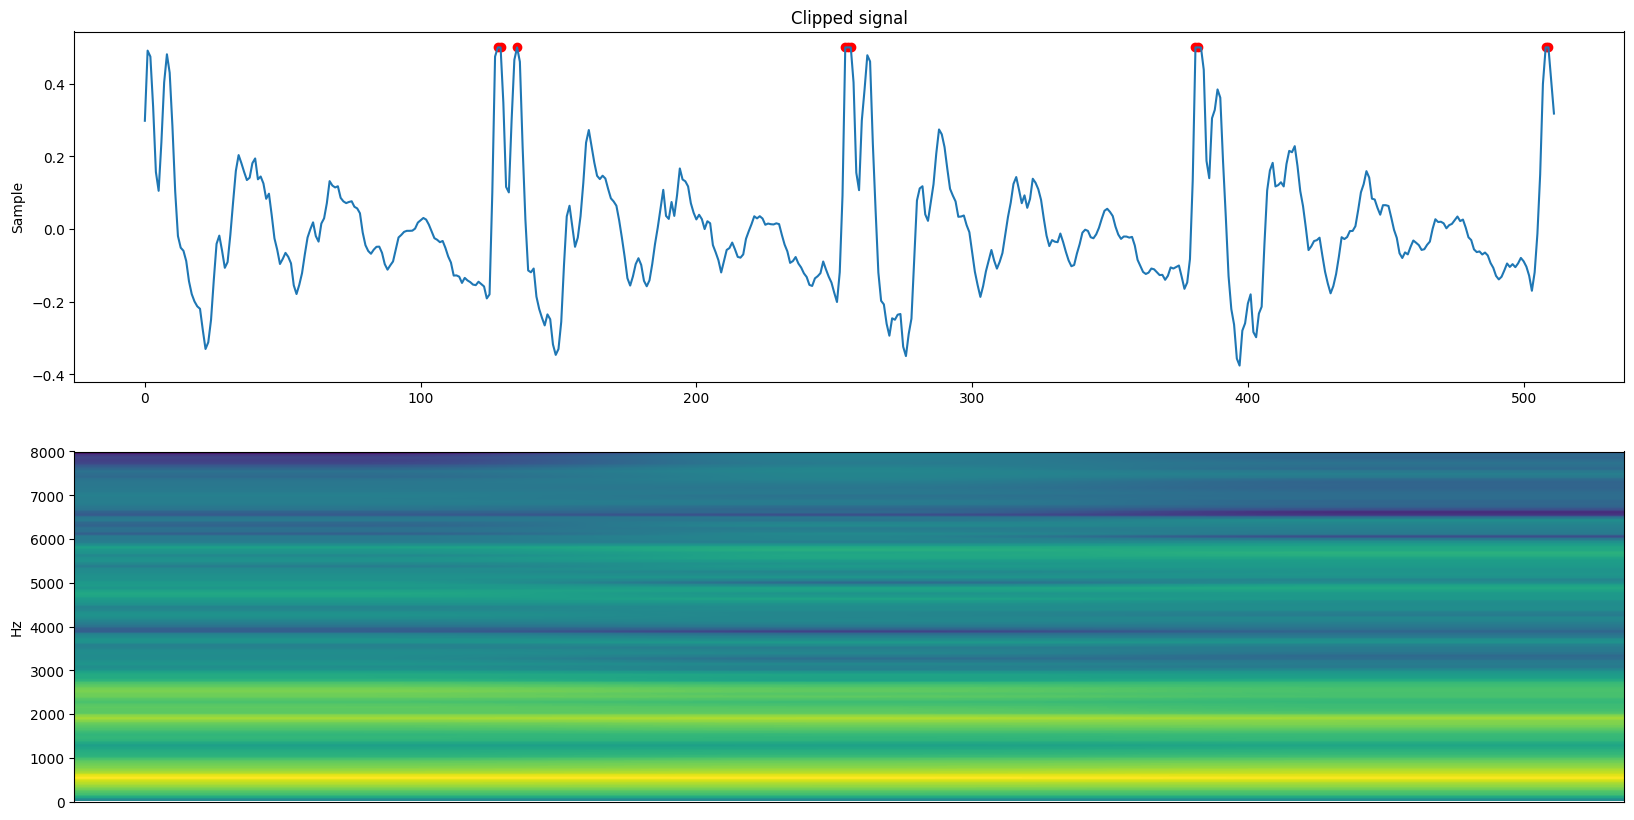

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

Fs = 16000
# load all files from directory
def load_dir(path):
    folder, _, files = next(os.walk(path))
    signals, srs = zip(*[librosa.load(os.path.join(folder, f),sr=None) for f in files])
    assert all(np.array(srs) == Fs)
    #remove mean
    return tuple(np.array(s - np.mean(np.array(s))) for s in signals)

# try to detect threshold and return indices of clipped samples
def detect_clipped(signal):
    mx = np.max(signal)
    return np.array(np.where(np.abs(signal) >= mx))

# plot example of clipped frame with its spectrogram
def plot_clipped(signal, clipped_indices, spectr=False, title=None):
    # try to find part where clipping is "most" visible
    frame_len = 512
    mid = np.median(clipped_indices).astype(int)
    # get frame around mid
    src = signal[mid-frame_len//2:mid+frame_len//2]
    clipped_src = clipped_indices - mid
    clipped_i = np.where(np.abs(clipped_src) < frame_len//2)[1]
    clipped_src = clipped_src[0][clipped_i] + frame_len//2

    # plot frame and it's spectrogram
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.title(title)
    plt.plot(src)
    plt.scatter(clipped_src, src[clipped_src], c='r')
    plt.gca().axes.get_yaxis().set_label_text('Sample')
    if spectr:
        plt.subplot(2, 1, 2)
        plt.specgram(src, Fs=Fs)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_label_text('Hz')
    plt.show()


signals_clp = load_dir('clipped_signals')
signals_orig = load_dir('orig_signals')

show_example1, show_example2 = 0, 50

test_file_clp = signals_clp[show_example1]
clipped = detect_clipped(test_file_clp)
plot_clipped(test_file_clp, clipped, spectr=True, title="Clipped signal")

## Úloha 2 - Výpočet SNR - `2 body `

Napište funkci pro výpočet poměru signálu k šumu, kde šum (jmenovatel) bude chyba (rozdíl mezi klipovaným signálem a originálem) a signál (čitatel) je originální signál. Spočítejte SNR způsobené klipováním pro všech 100 signálů. Berte je v úvahu celé, nejen klipované části.

---

### Vaše řešení:

$ SNR = 10 \cdot \log_{10} \left( \frac{\sum_{i=1}^{N} x_i^2}{\sum_{i=1}^{N} (x_i - y_i)^2} \right) $


Standardní vzorec pro výpočet SNR, kde $x_i$ je originální vzorek a $y_i$ je klipovaný vzorek. SNR je limitováno na 100dB pro zamezení NaN.

In [3]:
def snr(orig, modified):
    snr = 10 * np.log10(np.sum(orig**2) / np.sum((orig - modified)**2))
    return np.min([snr, 100])

test_file_orig = signals_orig[show_example1]
print("sample SNR:", snr(test_file_orig, test_file_clp), "dB")
print("sample SNR:", snr(signals_orig[show_example2], signals_clp[show_example2]), "dB")



sample SNR: 29.11029815673828 dB
sample SNR: 35.16718149185181 dB


## Úloha 3 - Oprava pomocí predikce zleva - ` 5 bodů`

Napište funkci, která bude opravovat klipované části. Měla by pracovat tak, že na L=240 vzorcích signálu před klipovanou částí odhadne koeficienty prediktoru a ten využije k náhradě klipovaných vzorků predikcí z minulosti. Vyberte 2 opravené segmenty a zobrazte je. Připravte dvě promluvy k přehrání (pokud budete pracovat v Py notebooku, přímo v něm, pokud v něčem jiném, jako několik WAV souborů). Vyzkoušejte délky prediktoru od P=2 do P=20. Pro každou délku vyhodnoťte na všech 100 signálech SNR a spočítejte redukci SNR oproti původnímu stavu (SNRR - v procentech). 

---


### Vaše řešení:

Pro výpočet LPC koeficientů využívám knihovnu librosa. Predikci pak provádím IIR filtrem.

In [4]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format


def lpc(signal, ordr):
    #r = np.correlate(signal,signal, mode='full')
    #r = r[len(r)//2:len(r)//2 + ordr + 1]
    #a = np.linalg.inv(scipy.linalg.toeplitz(r[:-2])) @ -r[1:-1]
    a = librosa.lpc(signal, order=ordr-1)[1:]
    return a,np.hstack([1.0, -a])

# repair clipped signal using LPC
def fix_LPC(signal, p=20, l=240):
    clips = detect_clipped(signal)
    repaired = signal.copy()
    for i in clips[0]:
        if i+l > len(repaired):
            break
        a,b = lpc(repaired[i - l:i], p)
        repaired[i] = scipy.signal.lfilter(-a, [1.0], repaired[i - l:i])[-1]
    return repaired


#todo lower step when done
param_step,param_min,param_max = 9,2,20

# create empty pandas table
PDheaders = [('clip','foo'),
             [('left',x) for x in range(param_min, param_max + 1,param_step)],
             [('right',x) for x in range(param_min, param_max + 1,param_step)],
             [('combined',x) for x in range(param_min, param_max + 1,param_step)],
             ('mymethod', 'foo')]
PDheaders_fix = []
for header in PDheaders:
    if type(header) == tuple:
        PDheaders_fix.append(header)
    else:
        PDheaders_fix += header
header = pd.MultiIndex.from_tuples(PDheaders_fix, names=['method', 'P'])
table = pd.DataFrame(columns=header)

#populate table with Nan
new_data = pd.DataFrame([[np.nan]*header.size], range(len(signals_clp)), header)
table = pd.concat([table, new_data], ignore_index=True)

#add original signal to table (for clip foo)
for i in range(len(signals_orig)):
    table.loc[i, ('clip', 'foo')] = snr(signals_orig[i], signals_clp[i])




# TODO asi nefaka :/
signals_leftLPC = []
for i in range(0,len(signals_orig),50): # TODO remove 50
    clp,orig = signals_clp[i], signals_orig[i]
    for p in range(param_min, param_max + 1,param_step):
        repr = fix_LPC(clp)
        table.loc[i, ('left', p)] = snr(orig,repr)
        if i in [show_example1, show_example2] and p == param_max:
            signals_leftLPC.append(repr)


#TODO add snrr
#for p in range(2,21,param_step):
#    table[('left', str(p) + " snrr %")] = table[('left', p)] / table[('clip', 'foo')] * 100
table

method  clip  left             right           combined           mymethod
P        foo     2    11    20     2   11   20        2   11   20      foo
0      29.11 19.04 19.04 19.04   NaN  NaN  NaN      NaN  NaN  NaN      NaN
1      29.13   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN
2      27.67   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN
3      31.34   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN
4      27.12   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN
..       ...   ...   ...   ...   ...  ...  ...      ...  ...  ...      ...
95     28.37   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN
96     28.65   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN
97     26.45   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN
98     31.06   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN
99     29.57   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN      NaN

[100 rows x 11 columns]

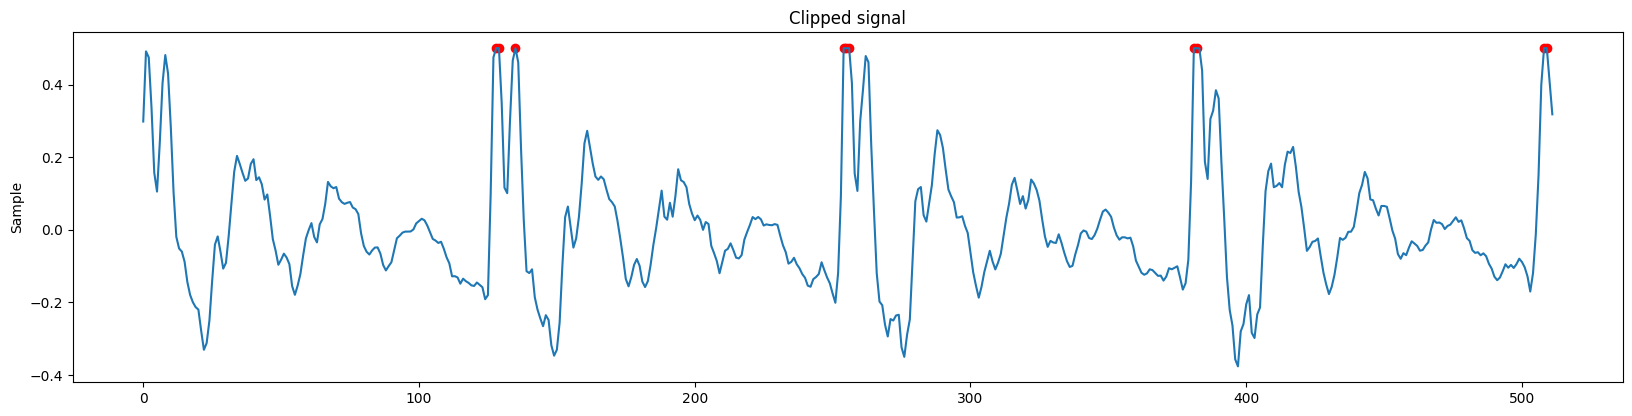

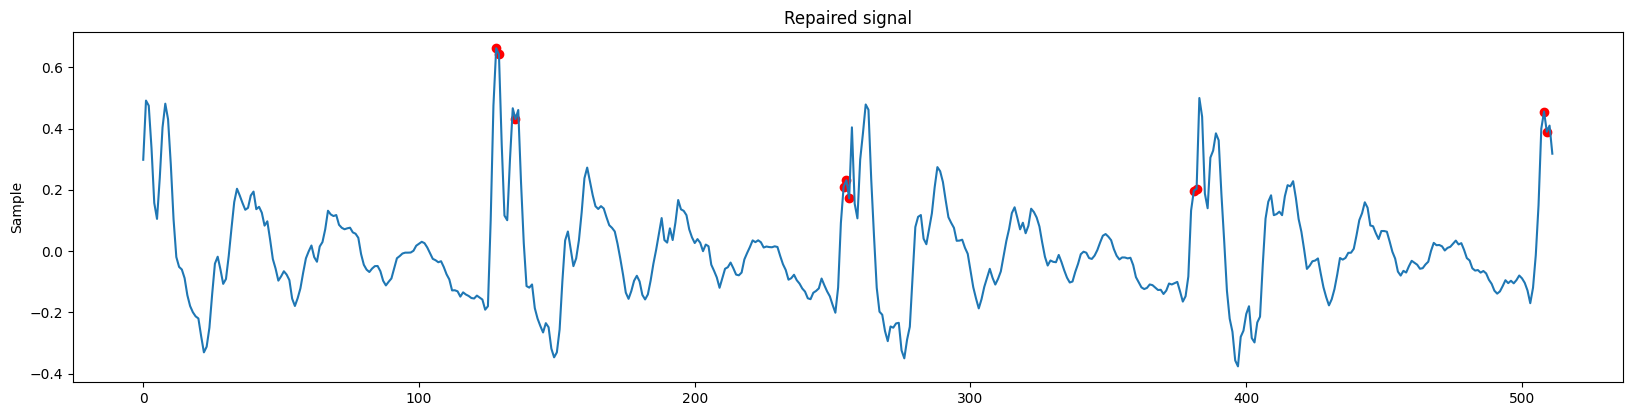

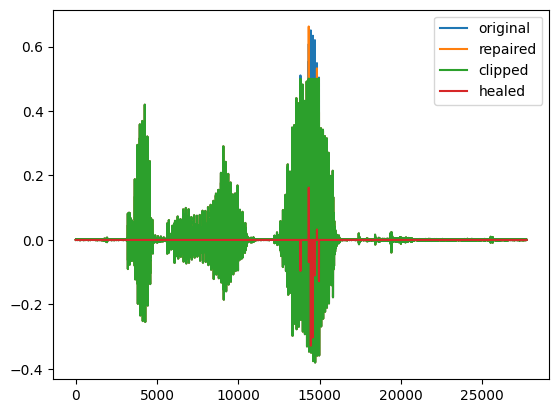

In [5]:
from IPython.display import Audio

def view_result(repaired, clip, orig):
    clipped = detect_clipped(clip)
    plot_clipped(clip, clipped, title="Clipped signal")
    plot_clipped(repaired, clipped,title="Repaired signal")

    fix, ax = plt.subplots()
    ax.plot(orig, label="original")
    ax.plot(repaired, label="repaired")
    ax.plot(clip, label="clipped")
    ax.plot(repaired - clip, label="healed")
    ax.legend()
    plt.show()

view_result(signals_leftLPC[0], signals_clp[show_example1], signals_orig[show_example1])
Audio(signals_leftLPC[0], rate=Fs)

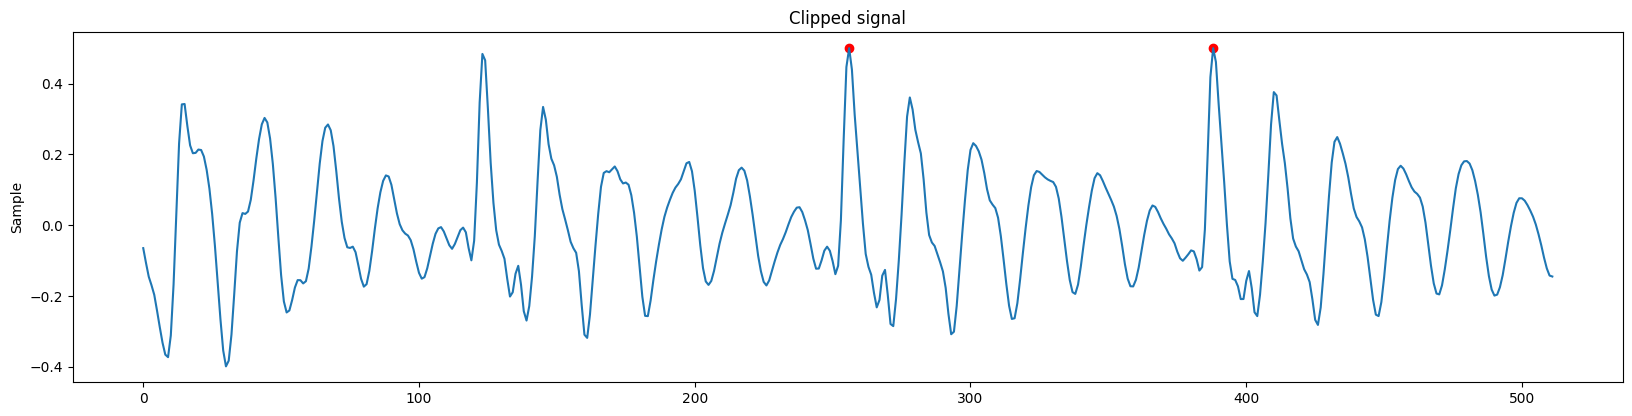

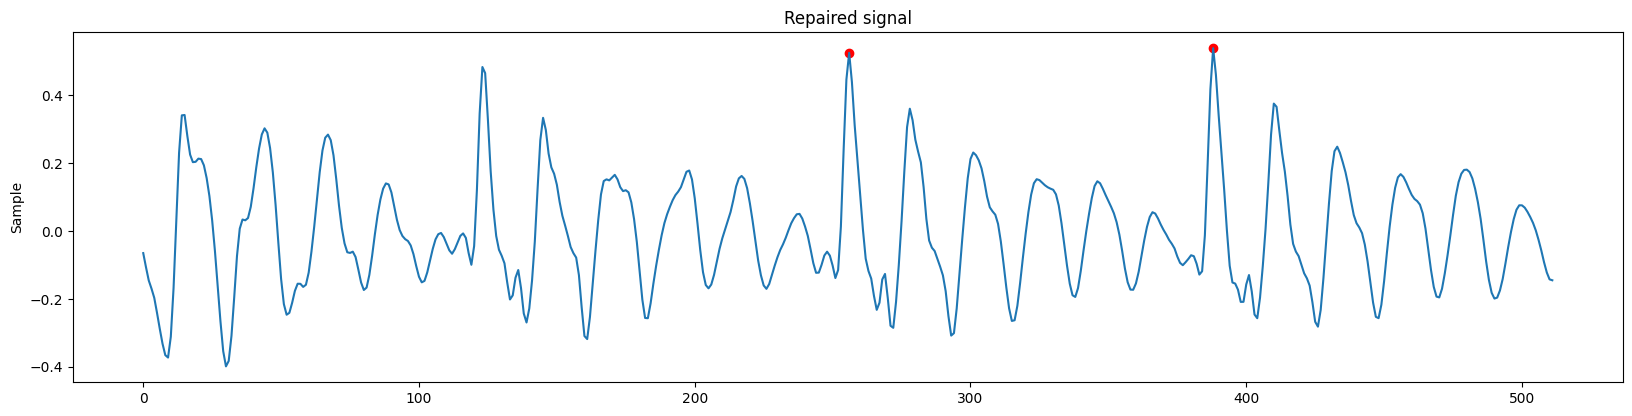

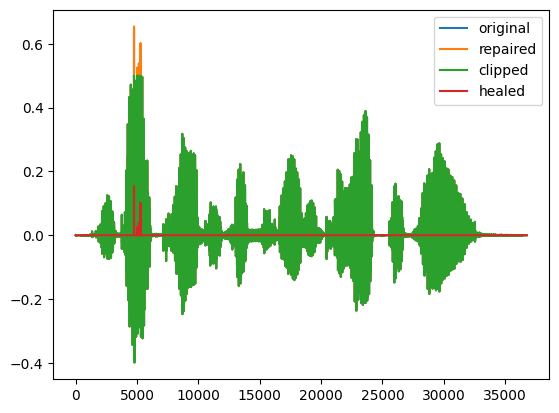

In [6]:
view_result(signals_leftLPC[1], signals_clp[show_example2], signals_orig[show_example2])
Audio(signals_leftLPC[1], rate=Fs)

## Úloha 4 - Oprava pomocí predikce zprava - ` 4 body`

Zopakujte předchozí cvičení, ale tentokrát predikujte klipované vzorky zprava (tedy z budoucnosti). Ve výpočtech budete tedy muset obracet signály nebo použít nekauzální filtry. Udělejte to samé, co v minulé cvičení, tedy vzorky k zobrazení a poslechu, závislost SNR a SNRR na délce prediktoru.

### Vaše řešení:

Predikce zprava probíha pouhým invertováním signálu.

In [7]:
# invert signal and predict
signals_rightLPC = []
for i in range(0,len(signals_orig),50): # TODO remove 50
    clp,orig = signals_clp[i], signals_orig[i]
    clp,orig = clp[::-1], orig[::-1]
    for p in range(param_min, param_max + 1,param_step):
        repr = fix_LPC(clp)
        table.loc[i, ('right', p)] = snr(orig,repr)
        if i in [show_example1, show_example2] and p == param_max:
            signals_rightLPC.append(repr[::-1])


#TODO add snrr
#for p in range(2,21,param_step):
#    table[('right', str(p) + " snrr %")] = table[('left', p)] / table[('clip', 'foo')] * 100
table

method  clip  left             right             combined           mymethod
P        foo     2    11    20     2    11    20        2   11   20      foo
0      29.11 19.04 19.04 19.04 31.04 31.04 31.04      NaN  NaN  NaN      NaN
1      29.13   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN
2      27.67   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN
3      31.34   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN
4      27.12   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN
..       ...   ...   ...   ...   ...   ...   ...      ...  ...  ...      ...
95     28.37   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN
96     28.65   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN
97     26.45   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN
98     31.06   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN
99     29.57   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN      NaN

[100 rows x 11 columns]

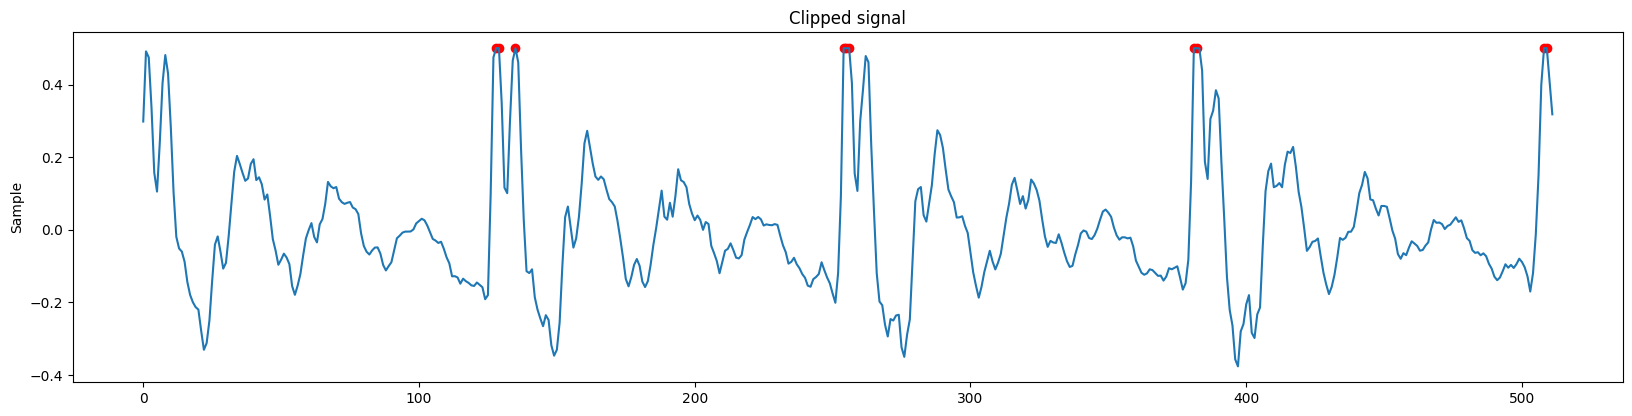

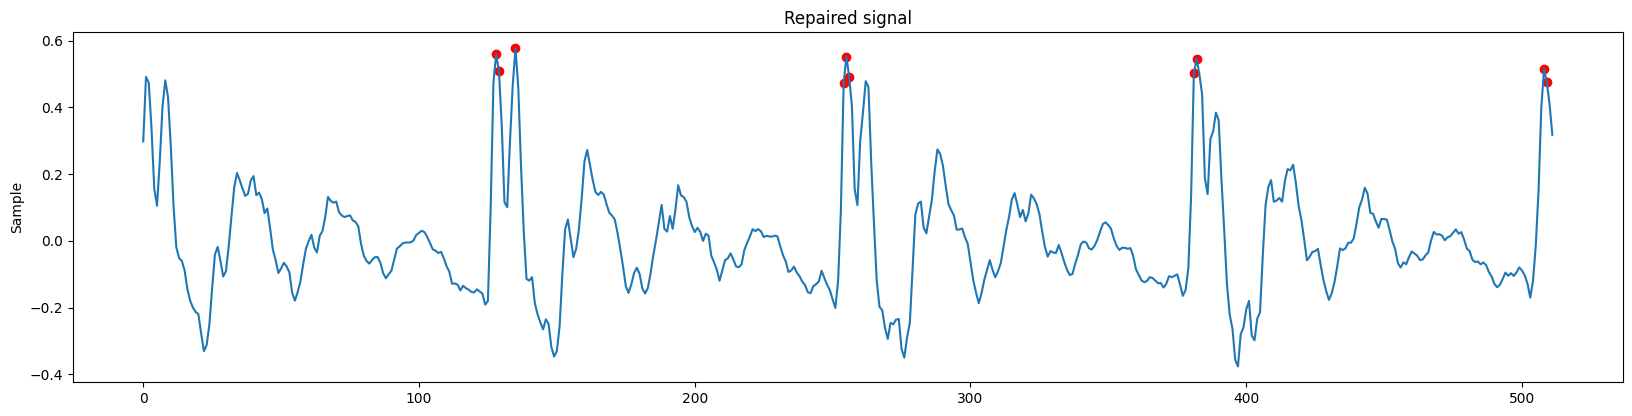

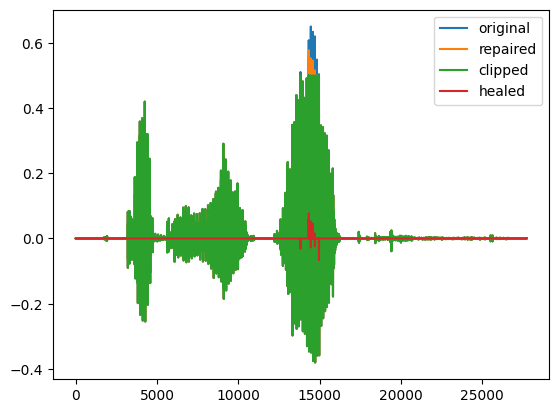

In [8]:
view_result(signals_rightLPC[0], signals_clp[show_example1], signals_orig[show_example1])
Audio(signals_rightLPC[0], rate=Fs)

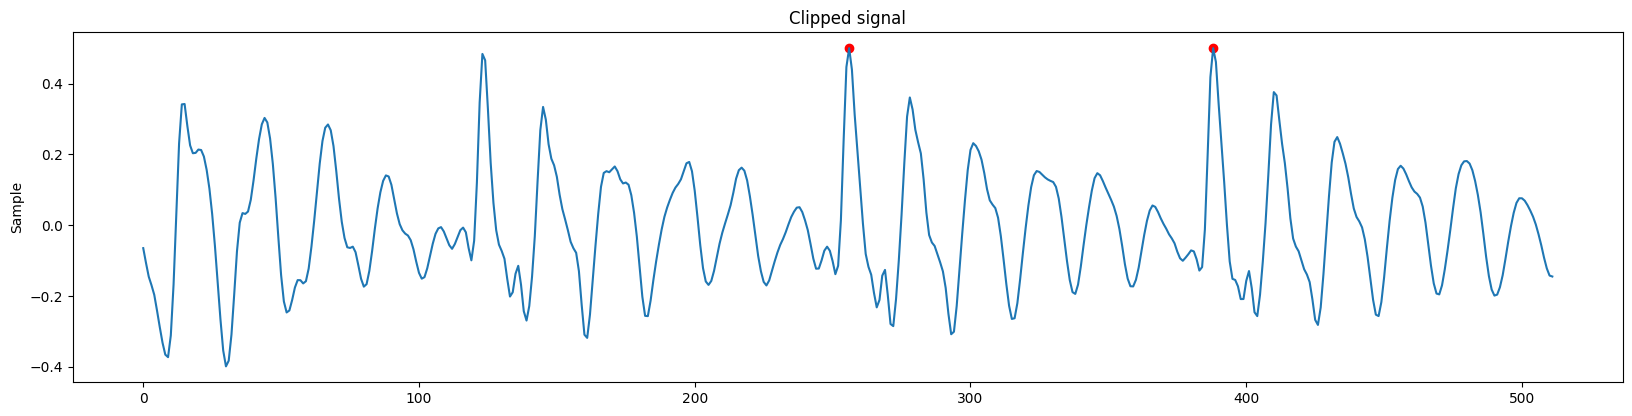

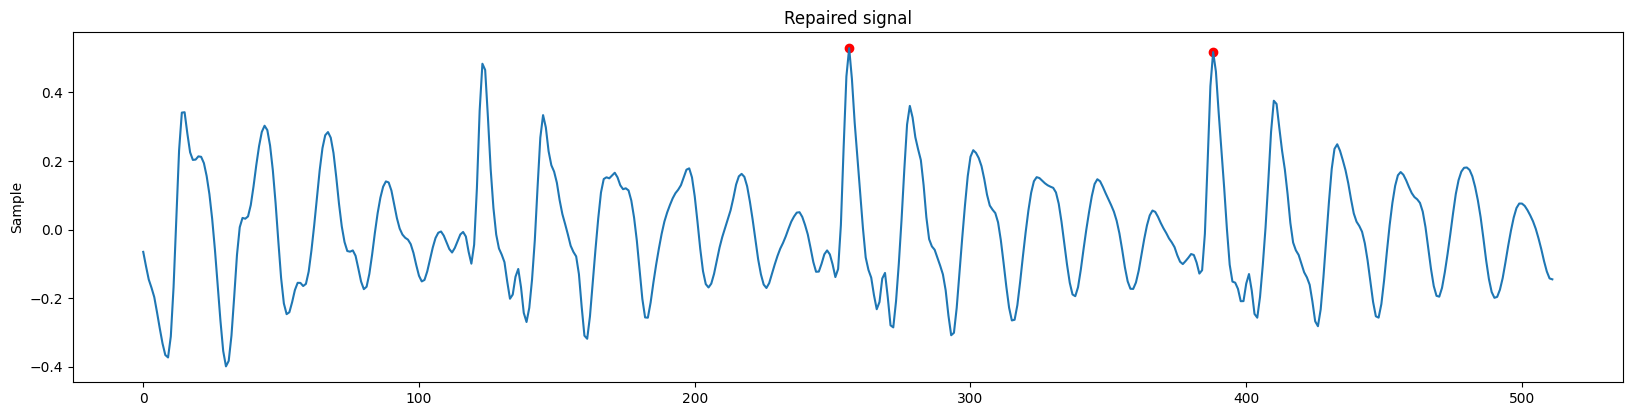

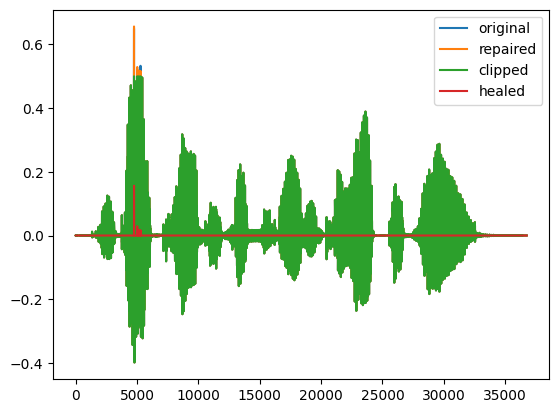

In [9]:
view_result(signals_rightLPC[1], signals_clp[show_example2], signals_orig[show_example2])
Audio(signals_rightLPC[1], rate=Fs)

## Úloha 5 - Lineární kombinace obou predikcí - ` 4 body`

Pro klipované vzorky proveďte lineární kombinaci obou predikcí, můžete vyzkoušet různé interpolace (s konstantními váhami 0,5 a 0,5, s klesajícím oknem zleva a stoupajícím zprava, cokoliv jiného). Proveďte opět ty samé kroky jako v minulých cvičeních, tedy vzorky k zobrazení a poslechu, závislost SNR a SNRR na délce prediktoru. 

---


### Vaše řešení:

V tomto podúkolu jsem použil prostou lineární kombinaci obou predikcí s váhou 0.5. Výsledky jsou v tabulce a níže jsou zobrazeny grafy a zvukové ukázky.

In [10]:
weight = 0.5
signals_combinedLPC = []
for i in range(0,len(signals_orig),50): # TODO remove 50
    clp,orig = signals_clp[i], signals_orig[i]
    clp_rev,orig_rev = clp[::-1], orig[::-1]
    for p in range(param_min, param_max + 1,param_step):
        repr = fix_LPC(clp)
        repr_rev = fix_LPC(clp_rev)[::-1]
        combined_repr = repr * weight + repr_rev * (1-weight)
        table.loc[i, ('combined', p)] = snr(orig,combined_repr)
        if i in [show_example1, show_example2] and p == param_max:
            signals_combinedLPC.append(combined_repr)


#TODO add snrr
#for p in range(2,21,param_step):
#    table[('combined', str(p) + " snrr %")] = table[('left', p)] / table[('clip', 'foo')] * 100

table

method  clip  left             right             combined             mymethod
P        foo     2    11    20     2    11    20        2    11    20      foo
0      29.11 19.04 19.04 19.04 31.04 31.04 31.04    23.43 23.43 23.43      NaN
1      29.13   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN
2      27.67   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN
3      31.34   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN
4      27.12   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN
..       ...   ...   ...   ...   ...   ...   ...      ...   ...   ...      ...
95     28.37   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN
96     28.65   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN
97     26.45   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN
98     31.06   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN
99     29.57   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN      NaN

[100 rows x 11 columns]

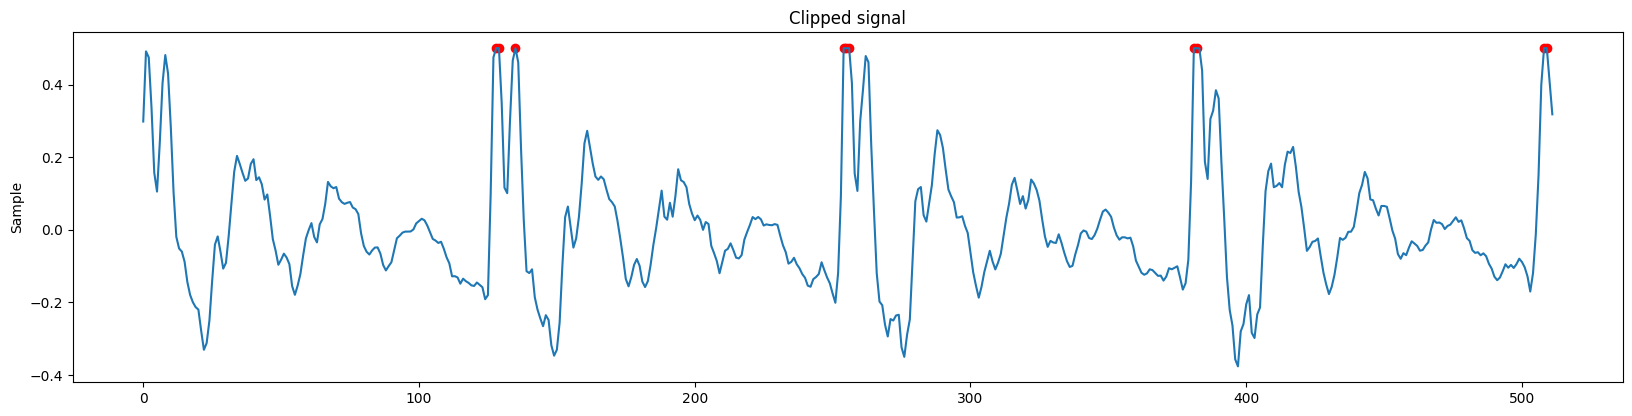

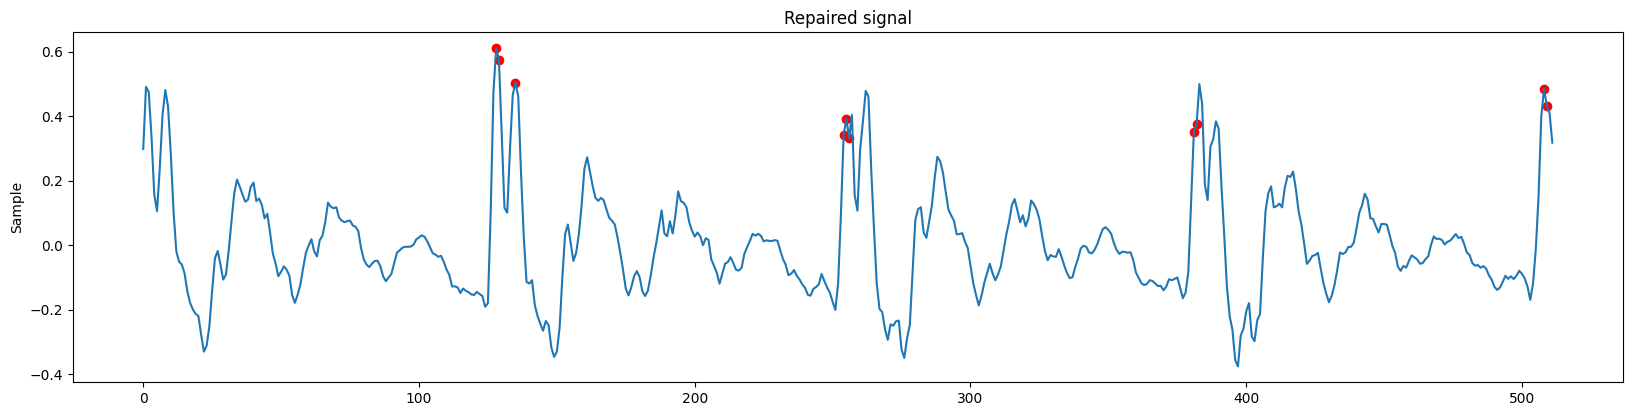

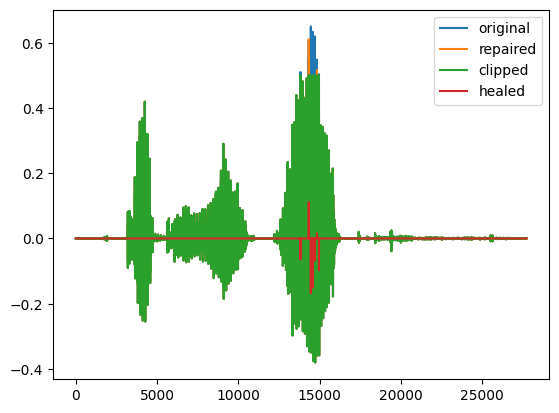

In [11]:
view_result(signals_combinedLPC[0], signals_clp[show_example1], signals_orig[show_example1])
Audio(signals_combinedLPC[0], rate=Fs)

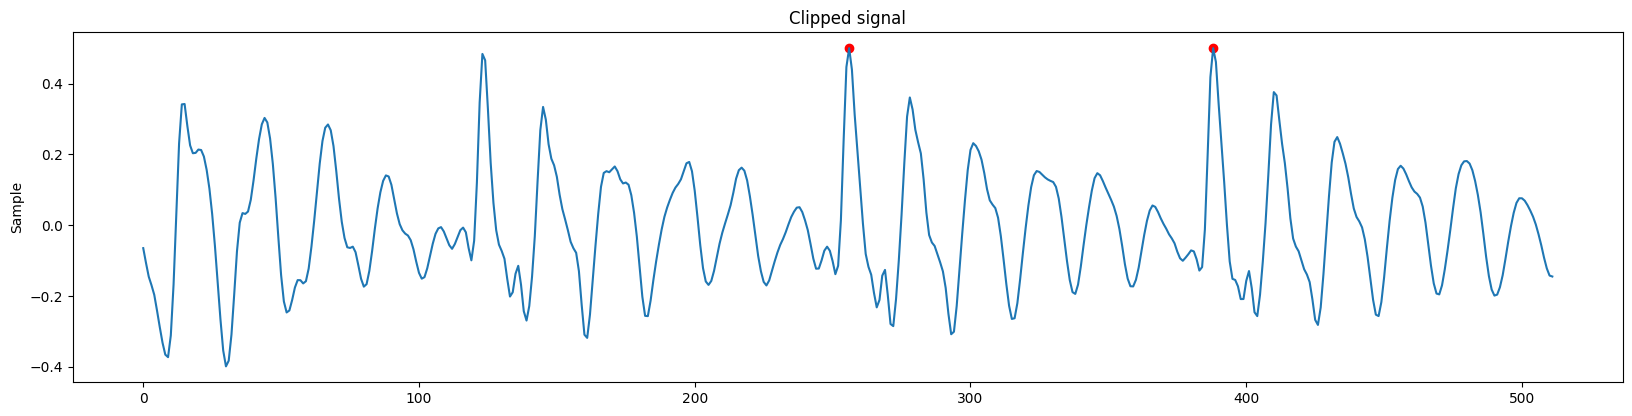

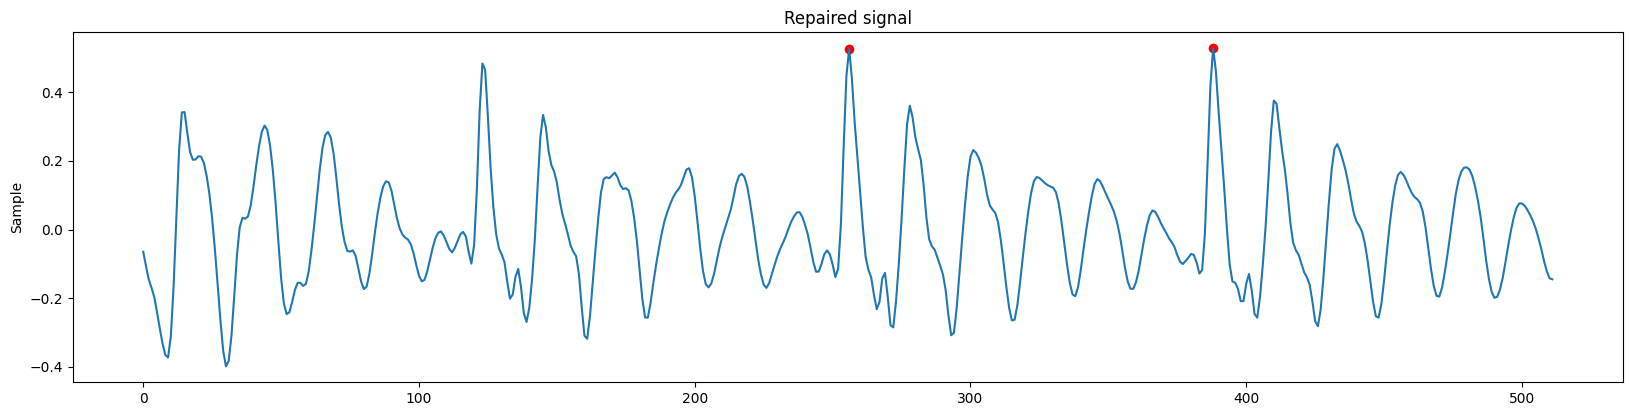

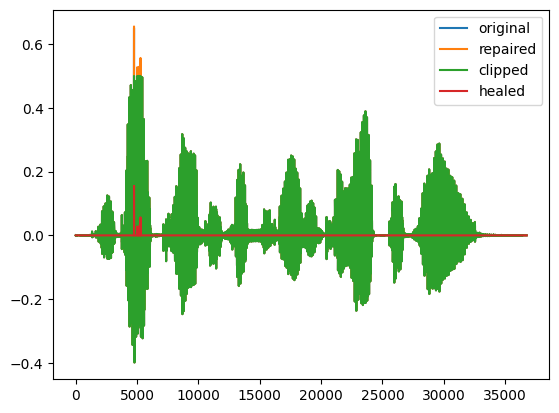

In [12]:
view_result(signals_combinedLPC[1], signals_clp[show_example2], signals_orig[show_example2])
Audio(signals_combinedLPC[1], rate=Fs)

## Úloha 6 - Cokoliv lepšího - ` 12 bodů`

Navrhněte a implementujte jakékoliv zlepšení rekonstrukce, možné příklady jsou: 

*   Optimalizace délky okna. 
*   Korektní práce s minulými či budoucími vzorky, pokud je za sebou více klipovaných částí (neměly by vstupovat do korelace pro výpočet R[k] a už vůbec ne do predikce vzorků)
*   Využití dynamické délky okna a dynamické délky prediktoru podle charakteru signálu. 
* Dlouhodobá predikce využívající základního tónu. 
* Analytické odvození, jak má predikce vzorků probíhat simultánně z levého či pravého kontextu nebo nalezení v literatuře a implementace. 
* Využití strojového učení (např. neuronová síť predikující vzorky)
* Cokoliv jiného  

Pro navrženou metodu proveďte opět ty samé kroky jako v minulých cvičeních, tedy vzorky k zobrazení a poslechu, a výpočet závislost SNR a SNRR. Komentujte výsledky. **Toto cvičení se bude obhajovat v pondělí 15. května**, nachystajte si prosím max. 10-minutovou presentaci - pár slajdů s popisem, co jste dělali, SNRR, ploty. 

---





### Vaše řešení:

Popište vaše řešení

In [13]:
def DCT_dictionary(frame_size=256, redundancy_factor=2):
    """
    DCT dictionary of size (frame_size)x(frame_size*redundancy_factor)
    """
    m = frame_size * redundancy_factor
    t = np.arange(frame_size)  # time
    k = np.arange(m)  # frequency

    D = np.cos(np.pi/m * np.dot((t[np.newaxis, :].T+1/2), k[np.newaxis, :]+1/2))

    D = D/np.sqrt(np.sum(D**2,0)) # normalize columns
    return	D

def consistentIHT(signal, clipped_samples_mat, D, iters = 100, non_zero = 32):
    """
    Consistent iterative hard thresholding for signal declipping, Kitic et al, ICASSP 2013

    Inputs:
        - clipped_samples_mat: bool vector, True if sample is clipped
        - D: fixed DCT dictionary

    Outputs:
        - A: sparse activation matrix
        - cost: loss vector
    """

    # initialize sparse coefficient matrix:
    a = np.zeros((D.shape[1]))

    mu = 1/np.linalg.norm(D,2)**2  # gradient descent parameter

    clipped_pos = np.logical_and(clipped_samples_mat, signal >= 0) # positive clipped samples
    clipped_neg = np.logical_and(clipped_samples_mat, signal <= 0) # negative clipped samples

    cost = np.zeros(iters)

    # compute residual:
    residual = signal - D @ a
    # enforce clipping consistency:
    residual[clipped_pos] = np.maximum(residual[clipped_pos],0)
    residual[clipped_neg] = np.minimum(residual[clipped_neg],0)

    cost[0] = np.sum(residual**2)

    for it in range(1,iters):
        # gradient descent step:
        a = a + mu * D.T@residual

        # hard thresholding:
        a = a * (abs(a) >= np.sort(np.abs(a),0)[a.shape[0]-non_zero])

        # compute residual:
        residual = signal - D @ a
        # enforce clipping consistency:
        residual[clipped_pos] = np.maximum(residual[clipped_pos],0)
        residual[clipped_neg] = np.minimum(residual[clipped_neg],0)

        # compute cost:
        cost[it] = np.sum(residual**2)
        if cost[it] < 1e-4:
            break

    return a, cost


def repair_clipped(signal,threshold=2):
    """
    Repair clipped samples using consistent iterative hard thresholding
    """
    clipped_samples = np.logical_or(signal<=-threshold,signal>=threshold)
    mask = np.ones(signal.shape)
    mask[clipped_samples] = 0
    if np.sum(clipped_samples) == 0:
        return signal
    a, _ = consistentIHT(signal,clipped_samples,D_DCT)
    sig_fix = D_DCT@a
    #apply mask to get rid of samples that were not clipped
    sig_fix2 = signal*mask + sig_fix*(1-mask)

    return sig_fix2

D_DCT = DCT_dictionary()


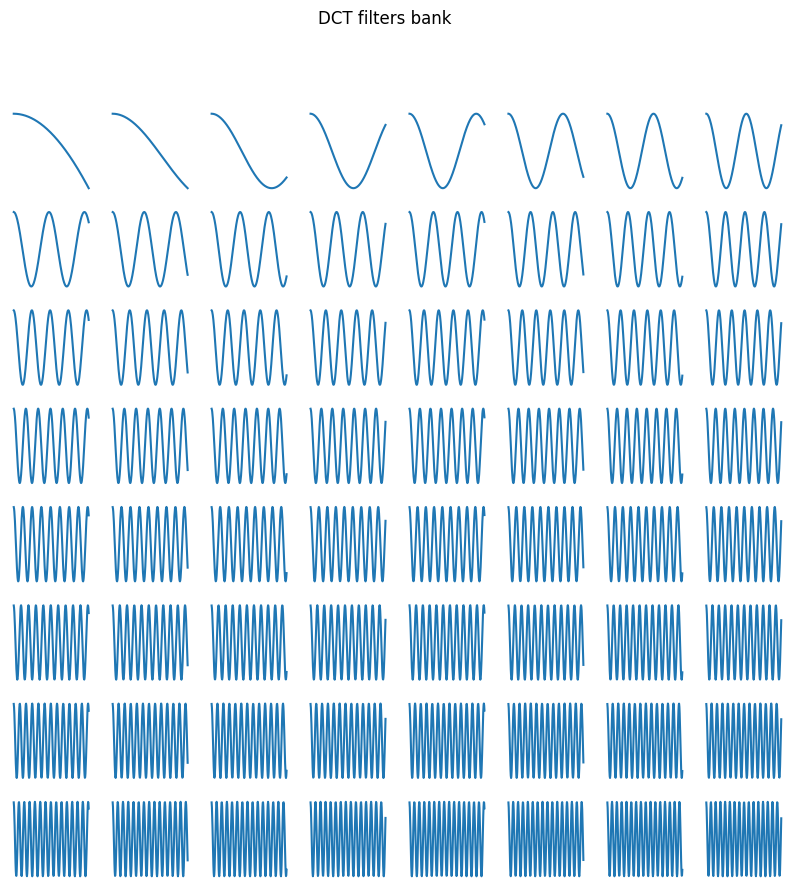

In [14]:
plt.figure(figsize=(10,10))
for i in range(0,64):
    plt.subplot(8,8,i+1)
    plt.plot(D_DCT[:,i])
    plt.axis('off')
plt.suptitle("DCT filters bank")
plt.show()

In [15]:
# repair clipped samples as whole
signals_IHT_wave = signals_orig
sample = signals_IHT_wave[0].copy()
thresh = np.max(sample)


for i in range(0,sample.shape[0], 256):
    #cutoff
    if i+256 > sample.shape[0]:
        break
    sample[i:i+256] = repair_clipped(sample[i:i+256],thresh)

cl23=1
sample2=signals_IHT_wave[cl23].copy()
for i in range(0,sample2.shape[0], 256):
    #cutoff
    if i+256 > sample2.shape[0]:
        break
    sample2[i:i+256] = repair_clipped(sample2[i:i+256],thresh)

snr_IHT_wave = snr(signals_orig[cl23],sample2)
print("SNR IHT wave: ", snr_IHT_wave)
print("SNR CLP: ", snr(signals_orig[cl23],signals_clp[cl23]))
print("SNR left: ", snr(signals_orig[cl23],signals_leftLPC[cl23]))
print("SNR right: ", snr(signals_orig[cl23],signals_rightLPC[cl23]))
print("SNR comb: ", snr(signals_orig[cl23],signals_combinedLPC[cl23]))



SNR IHT wave:  100.0
SNR CLP:  29.126310348510742


/tmp/ipykernel_81811/2889487200.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  snr = 10 * np.log10(np.sum(orig**2) / np.sum((orig - modified)**2))


ValueError: operands could not be broadcast together with shapes (42804,) (36762,) 

In [ ]:

snr_IHT_wave = snr(signals_orig[0],sample)
print("SNR IHT wave: ", snr_IHT_wave)
print("SNR CLP: ", snr(signals_orig[0],signals_clp[0]))
print("SNR left: ", snr(signals_orig[0],signals_leftLPC[0]))
print("SNR right: ", snr(signals_orig[0],signals_rightLPC[0]))
print("SNR comb: ", snr(signals_orig[0],signals_combinedLPC[0]))
#plot
#zoom_sec =

c1 = 14500
c2 = c1+256
plt.figure(figsize=(20,5))
plt.plot(signals_orig[0][(c1//256)*256:(c2//256)*256], label="original")
plt.plot(sample[(c1//256)*256:(c2//256)*256], label="IHT wave", alpha=0.9,linestyle="--")
plt.plot(signals_clp[0][(c1//256)*256:(c2//256)*256], label="clp", alpha=0.5,linestyle=":")
plt.plot((signals_orig[0]-sample)[(c1//256)*256:(c2//256)*256], label="repair-orig diff")
plt.plot((signals_orig[0]-signals_clp[0])[(c1//256)*256:(c2//256)*256], label="clp-orig diff", alpha=0.5,linestyle=":")
plt.legend()
plt.show()

#jee kvuli spatnemu kontextu zkusim stredovani ( 127 - 127 ) z okna


# Hodnocení

Viz zadání. Jak je v ZRE zvykem, student/ka s nejinovativnějším / nejzajímavějším řešením dostane láhev dobrého červeného.